In [2]:
import sys
import warnings
import datacube
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
import pandas as pd
import xarray as xr
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff
import os

sys.path.append('../10_Scripts')
import SpatialTools
import gdal
import DEADataHandling
import DEAPlotting

In [1]:
# Connect to datacube database
dc = datacube.Datacube(app='Snow monitoring with Landsat')


output='results/threshold_02/mask/'

('2002-01-01', '2003-12-31'), ('2004-01-01', '2005-12-31'), ('2006-01-01', '2007-12-31')

year='2004'

# Set up centre of area to analyse, and a buffer in metres around this centrepoint. Generally,
# aim to keep the buffer size to less than 10,000m to prevent having memory errors

lat, lon, buffer_m = -36.3, 148.35, 8000

# Set range of time to return data from both Landsat and Sentinel 2
time_range = ('2004-01-01', '2004-12-31')

resolution = (-25, 25)

landsat_goodquality_prop = 0.3

ndsi_threshold = 0.2
ndvi_threshold = 0.3
ndwi_threshold = 0.15

x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_m, y + buffer_m),    
         'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution}

NameError: name 'datacube' is not defined

In [256]:
print('loading landsat_ds')
snow_mask = dict(                cloud_acca='no_cloud',
                                 #cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 #cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True)

landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query,
                                               mask_dict=snow_mask,
                                               sensors=['ls5','ls7','ls8'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=True,
                                               ls7_slc_off=True)

loading landsat_ds
Loading ls5
    Loading 27 filtered ls5 timesteps
Loading ls7
    Loading 22 filtered ls7 timesteps
Loading ls8
    Skipping ls8; no valid data for query
Combining and sorting ls5, ls7 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [279]:
ndsi_ds = (landsat_ds.green -landsat_ds.swir1) / (landsat_ds.green + landsat_ds.swir1)
ndvi_ds = (landsat_ds.nir - landsat_ds.red) / (landsat_ds.nir + landsat_ds.red)
ndwi_ds = (landsat_ds.green - landsat_ds.nir)/(landsat_ds.green + landsat_ds.nir)

valid_ds = np.isfinite(landsat_ds.swir1)

snow_ds1 = ndsi_ds > ndsi_threshold
noveg_ds = ndvi_ds < ndvi_threshold
nowater_ds = ndwi_ds < ndwi_threshold
snow_ds = noveg_ds & snow_ds1 & nowater_ds

In [271]:
# ndsi_ds.isel(time=1).plot()

In [258]:
snow_ds['time.month']

<xarray.DataArray 'month' (time: 49)>
array([ 1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  4,
        4,  4,  5,  5,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,  9, 10, 10,
       10, 10, 10, 10, 10, 11, 11, 11, 12, 12, 12, 12, 12])
Coordinates:
  * time     (time) datetime64[ns] 2004-01-03T23:45:47.500000 ... 2004-12-29T23:40:01.500000

In [280]:
snow_sum = snow_ds.groupby('time.month').sum(dim='time')
valid_sum = valid_ds.groupby('time.month').sum(dim='time')
snow_prop = (snow_sum / valid_sum)

In [295]:
# snow_sum.isel(month=7).plot(cmap='Blues')
# valid_sum.isel(month=7).plot(cmap='Reds')


In [ ]:
# snow_month=snow_sum.where(snow_sum<1, ndsi_ds)

In [281]:
snow_month=snow_sum.where(snow_sum<1, 1)
valid_month=valid_sum.where(valid_sum<1,1)


In [283]:
snow_sum_pp=snow_month.sum(dim=['month'])
# snow_sum_pp.plot(cmap='Blues', robust=True, figsize=(8,8))

In [289]:
t = list(range(len(snow_month)))
# for i in t:
#     snow_prop_month.isel(month=i).plot()

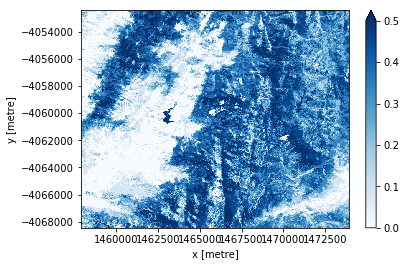

In [325]:
snow_month_sum=snow_month.sum(dim=['month'])
valid_month_sum=valid_month.sum(dim=['month']) # valis
snow_prop_month1 = snow_month_sum/valid_month_sum
snow_prop_month1.plot(cmap='Blues', robust=True)

In [316]:
type(snow_month)

xarray.core.dataarray.DataArray

In [318]:
transform, projection = SpatialTools.geotransform(snow_prop_perpixel, (snow_prop_perpixel.x, snow_prop_perpixel.y), epsg=3577)
SpatialTools.array_to_geotiff(str(year)+'annual_plot.tif',
              snow_prop_month1.values, geo_transform = transform, 
              projection = projection, 
              nodata_val=np.nan)

This function is written for use with the GDAL run 'array_to_geotiff' function and should be used with extreme caution elsewhere.


In [323]:
snow_prop_month1.to_netcdf('annual_snowprop_'+str(year)+'.nc')
snow_month_sum.to_netcdf('annual_snowsum_'+str(year)+'.nc')
valid_month_sum.to_netcdf('annual_validsum_'+str(year)+'.nc')

In [324]:
snow_month.to_netcdf('annual_snow_'+str(year)+'.nc')
valid_month.to_netcdf('annual_validpix_'+str(year)+'.nc')

In [303]:
# year = 2004
# from matplotlib.backends.backend_pdf import PdfPages
# import matplotlib.dates as mdates
# import matplotlib.pyplot as plt
# import matplotlib.backends.backend_pdf
# pdf = matplotlib.backends.backend_pdf.PdfPages('annual_snow_'+str(year)+'.pdf')


# # fig, ax = plt.subplots(figsize=(14,5))
# snow_prop_month1.plot(cmap='Blues', robust=True)
# # plt.ylim(-1, 1)
# plt.title('Annual_snow'+str(year))
# # plt.xlabel('Days of the year')
# # plt.ylabel('ave NDSI for valid pixels over 1200m')
# # fig.colorbar(sp)
# pdf.savefig()

# pdf.close()

In [ ]:
valid_sum_perpixel = valid_ds.sum(dim=['time'])
snow_prop_perpixel = (snow_sum_perpixel / valid_sum_perpixel)

In [210]:
# a.isel(month=0).plot()

In [163]:
snow_sum_perpixel = snow_sum.sum(dim=['month'])
valid_sum_perpixel = valid_ds.sum(dim=['time'])
snow_prop_perpixel = (snow_sum_perpixel / valid_sum_perpixel)
#snow_sum_perpixel.plot(cmap='Blues', robust=True)

In [28]:
snow_sum_perpixel = snow_ds.sum(dim=['time'])
valid_sum_perpixel = valid_ds.sum(dim=['time'])
snow_prop_perpixel = (snow_sum_perpixel / valid_sum_perpixel)
#snow_sum_perpixel.plot(cmap='Blues', robust=True)

In [19]:
transform, projection = SpatialTools.geotransform(snow_prop_perpixel, (snow_prop_perpixel.x, snow_prop_perpixel.y), epsg=3577)
SpatialTools.array_to_geotiff('out1_snow.tif',
              snow_prop_perpixel.values, geo_transform = transform, 
              projection = projection, 
              nodata_val=np.nan)

This function is written for use with the GDAL run 'array_to_geotiff' function and should be used with extreme caution elsewhere.


In [30]:

# snow_sum_perpixel.plot(cmap='Blues', robust=True, figsize=(8,8))